<a href="https://colab.research.google.com/github/Saul-Ochoa/Time-Series/blob/main/Forecasting%20/stocks-shares/%5EGSPC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yahhoo**

In [39]:
pip install yahoofinancials

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import missingno as msno
import math

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

# Descargar datos de yahoo
import yfinance as yf
from yahoofinancials import YahooFinancials
plt.style.use("fivethirtyeight")

import warnings
warnings.filterwarnings('ignore')

In [41]:
df = yf.download("^GSPC",
                      start='2012-01-01',
                      end='2023-11-01',
                      progress=False)
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3943710000
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3592580000
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4315950000
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3656830000
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3371600000


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2977 entries, 2012-01-03 to 2023-10-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2977 non-null   float64
 1   High       2977 non-null   float64
 2   Low        2977 non-null   float64
 3   Close      2977 non-null   float64
 4   Adj Close  2977 non-null   float64
 5   Volume     2977 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 162.8 KB


In [43]:
df = df.asfreq('B')

In [44]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,1258.859985,1284.619995,1258.859985,1277.060059,1277.060059,3.943710e+09
2012-01-04,1277.030029,1278.729980,1268.099976,1277.300049,1277.300049,3.592580e+09
2012-01-05,1277.300049,1283.050049,1265.260010,1281.060059,1281.060059,4.315950e+09
2012-01-06,1280.930054,1281.839966,1273.339966,1277.810059,1277.810059,3.656830e+09
2012-01-09,1277.829956,1281.989990,1274.550049,1280.699951,1280.699951,3.371600e+09


In [45]:
print(df.index.min())
print(df.index.max())

2012-01-03 00:00:00
2023-10-31 00:00:00


In [46]:
df.shape

(3086, 6)

In [47]:
df.isnull().sum()

Open         109
High         109
Low          109
Close        109
Adj Close    109
Volume       109
dtype: int64

<Axes: >

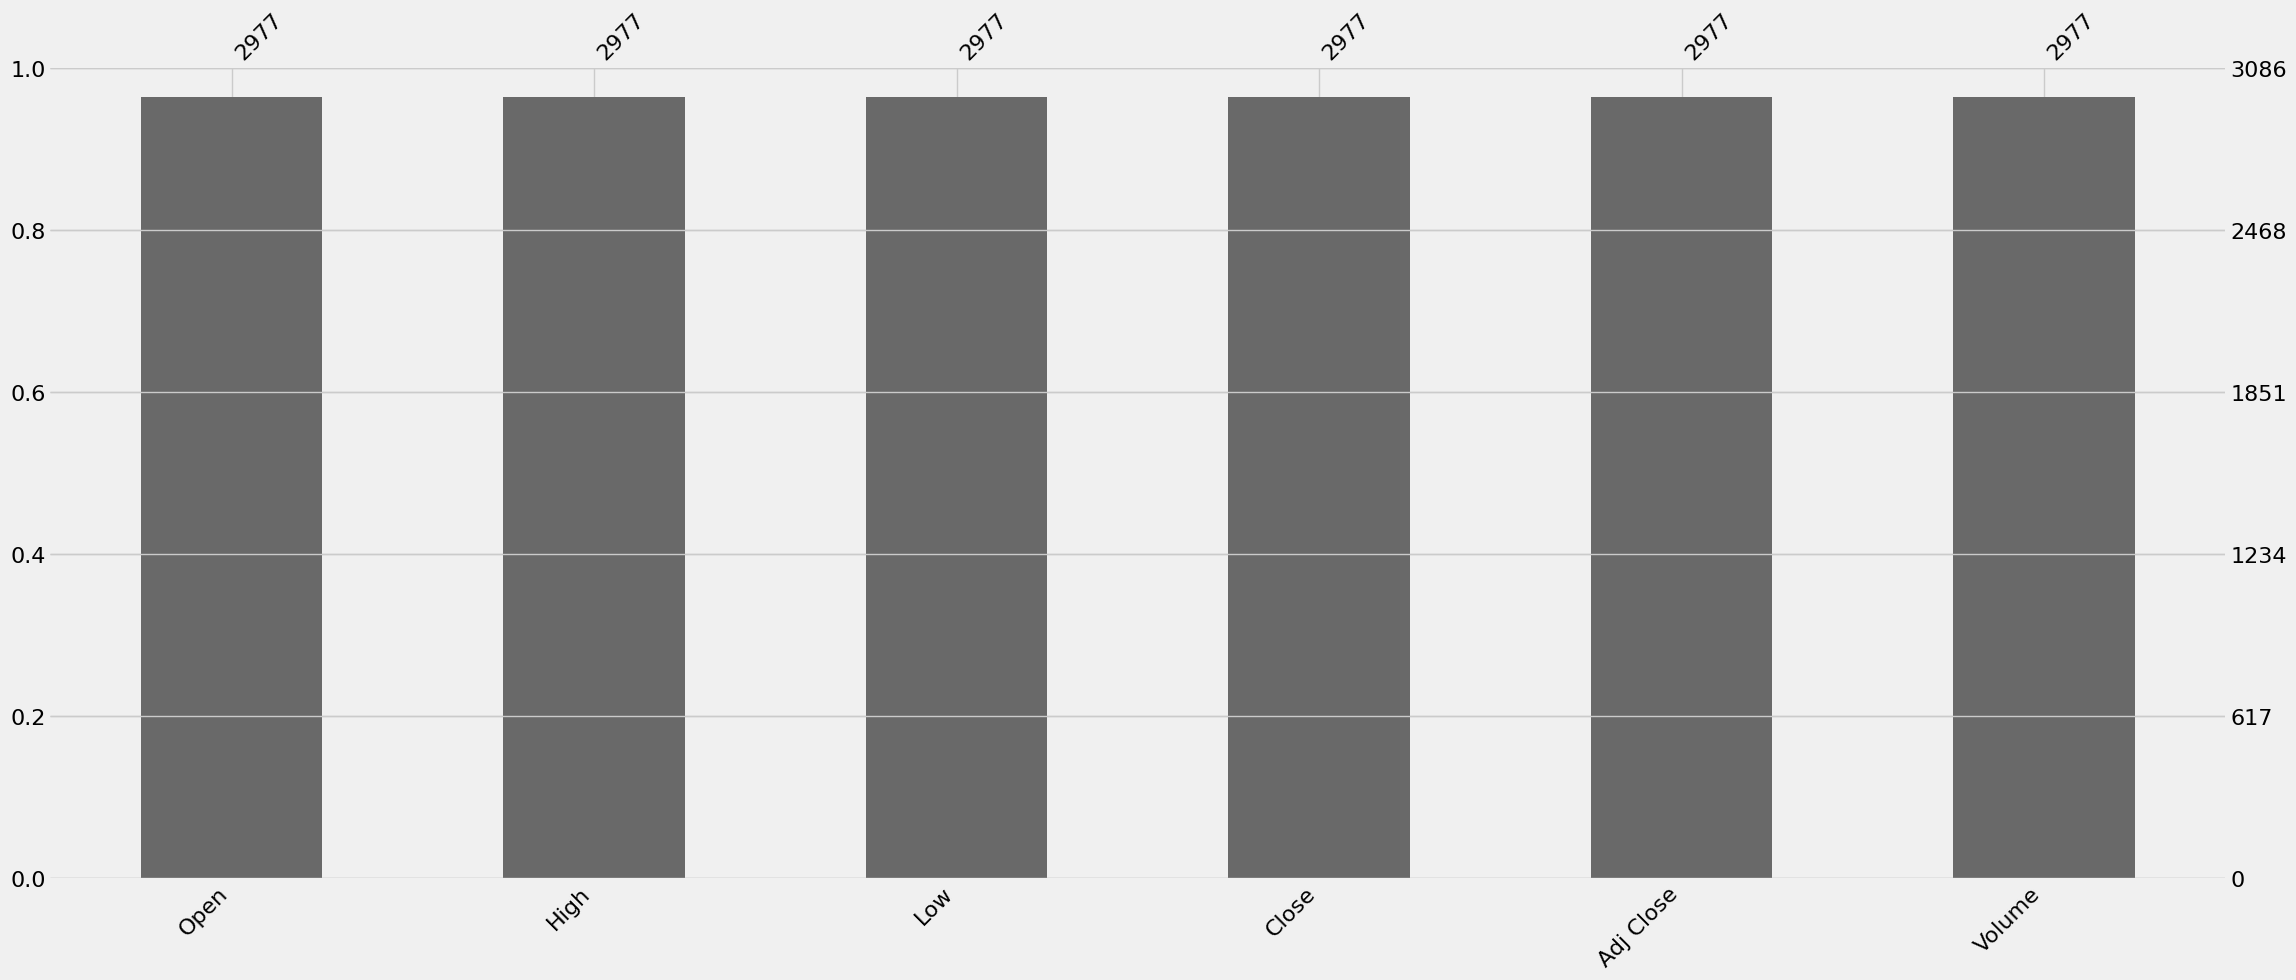

In [48]:
msno.bar(df)

<Axes: >

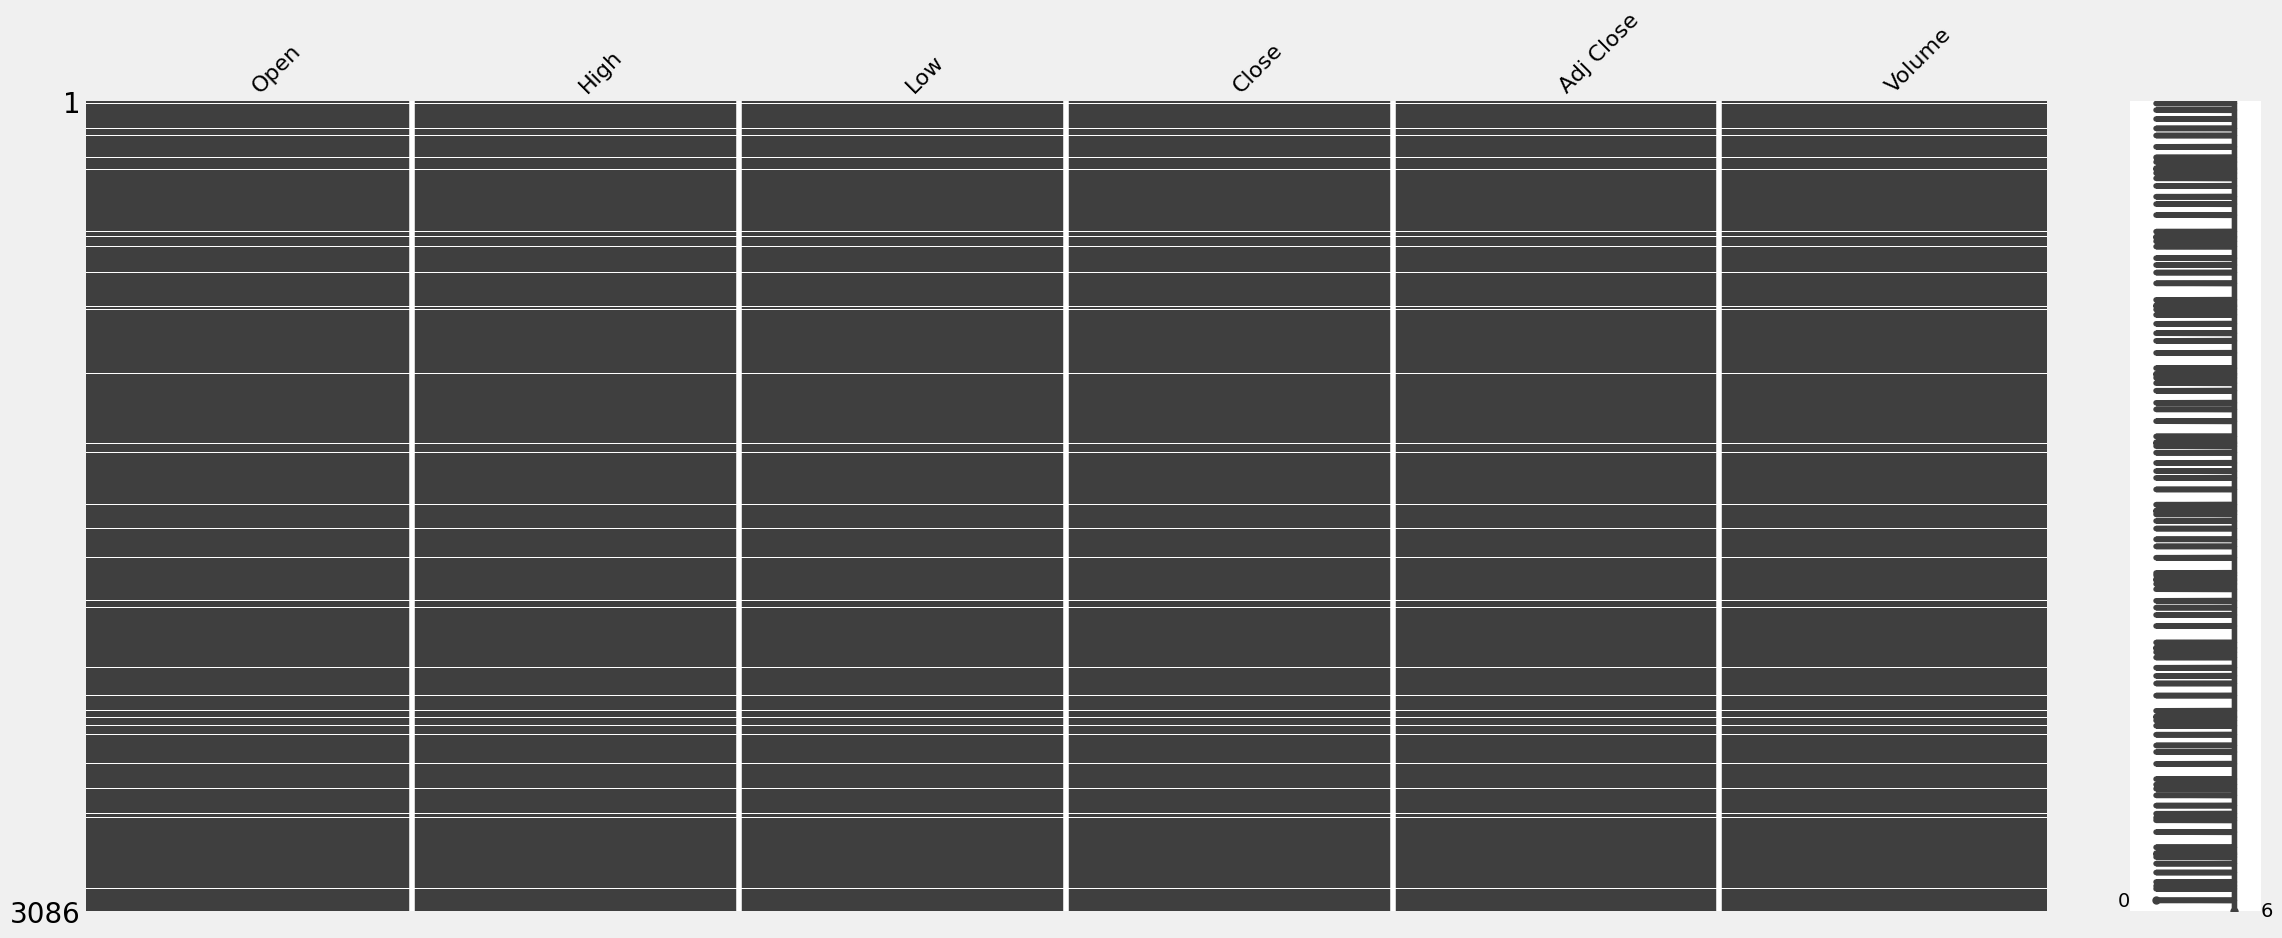

In [49]:
msno.matrix(df)

<Axes: >

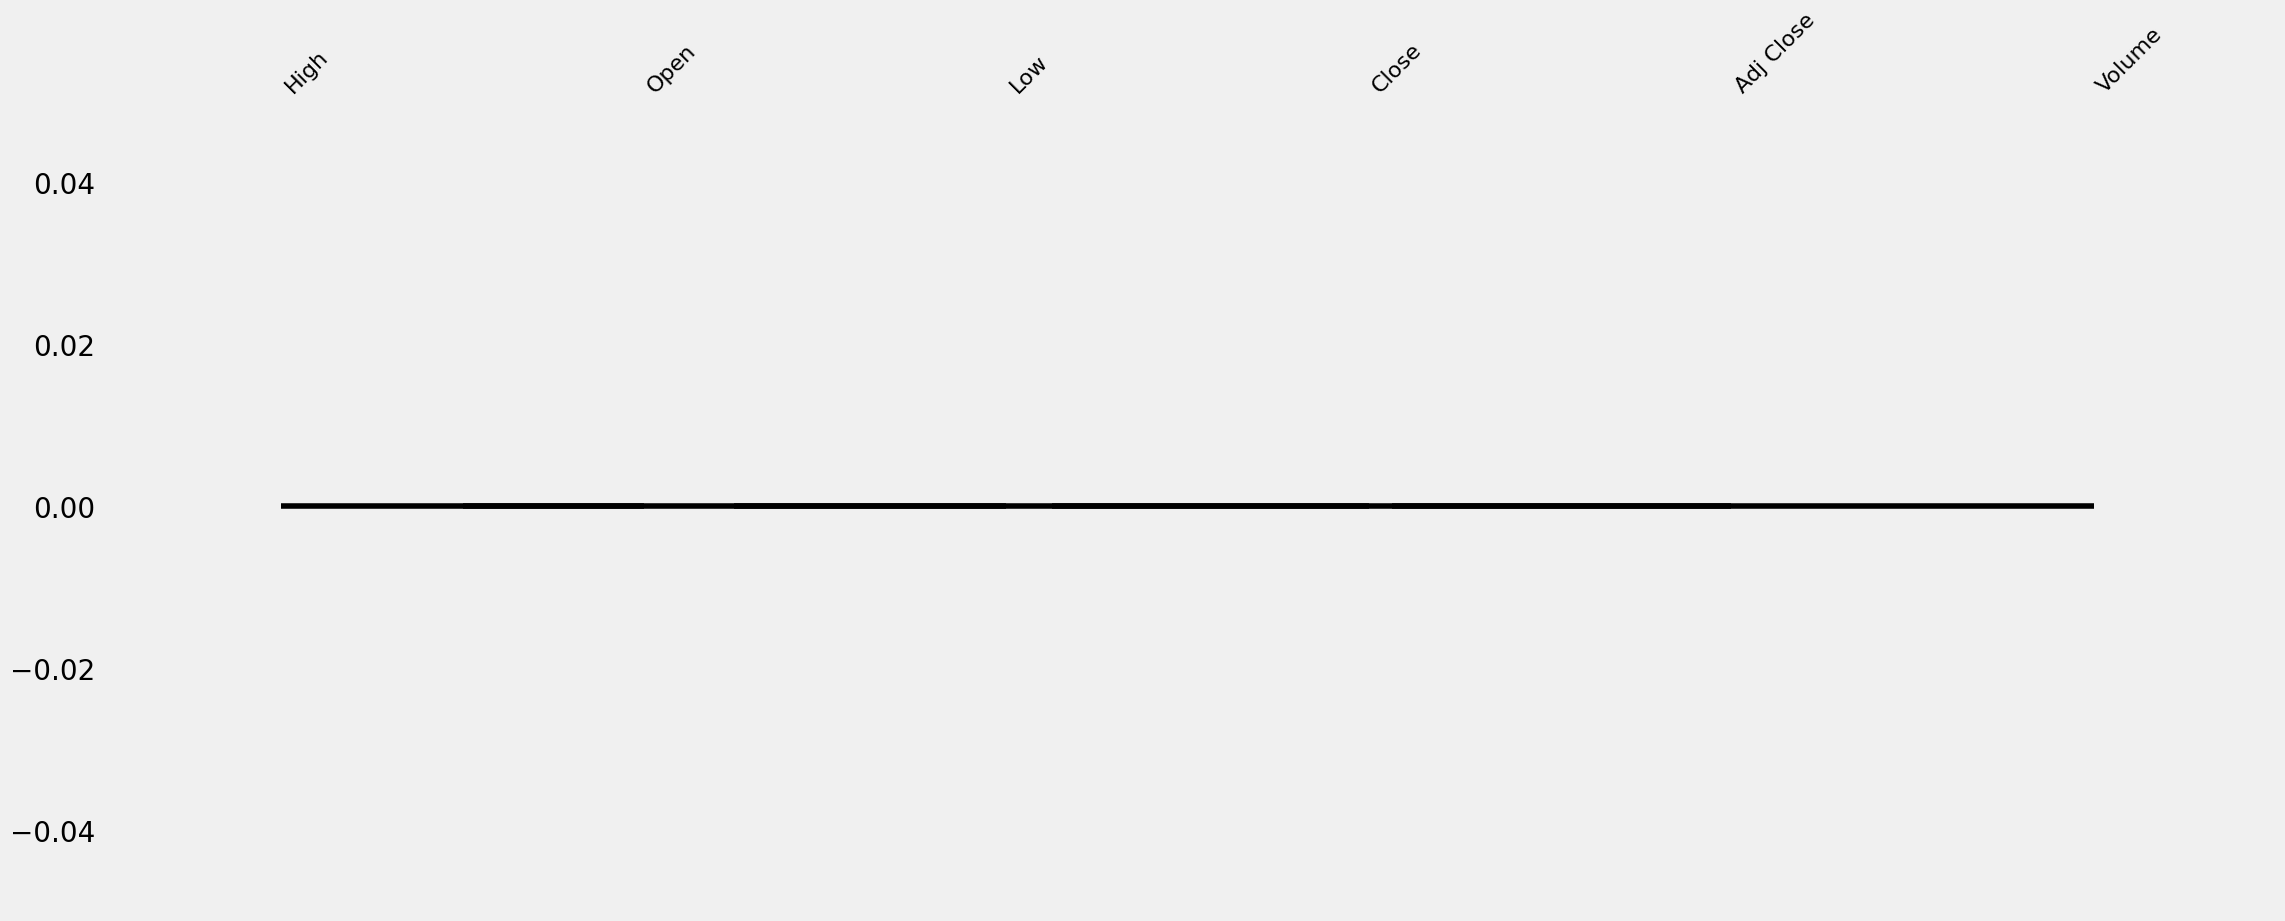

In [50]:
msno.dendrogram(df)

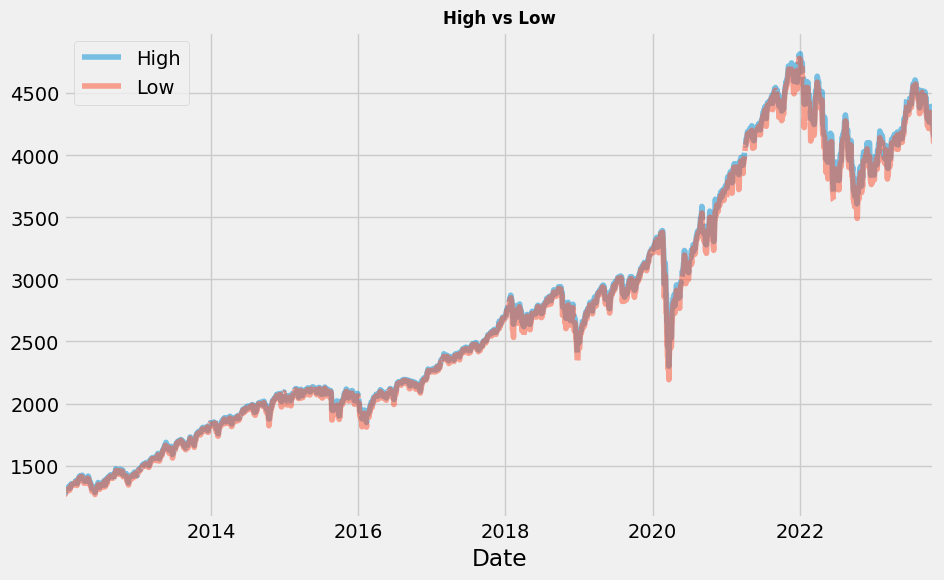

In [51]:
df[['High','Low']].plot(figsize=(10,6),alpha=0.5)
plt.title('High vs Low',fontsize=12,weight='bold')
plt.show()

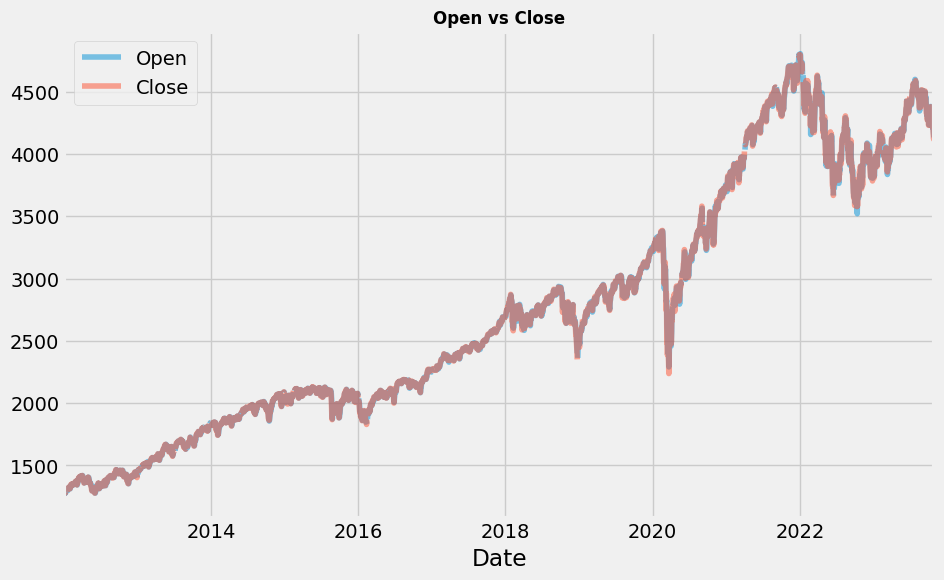

In [52]:
df[['Open','Close']].plot(figsize=(10,6),alpha=0.5)
plt.title('Open vs Close',fontsize=12,weight='bold')
plt.show()

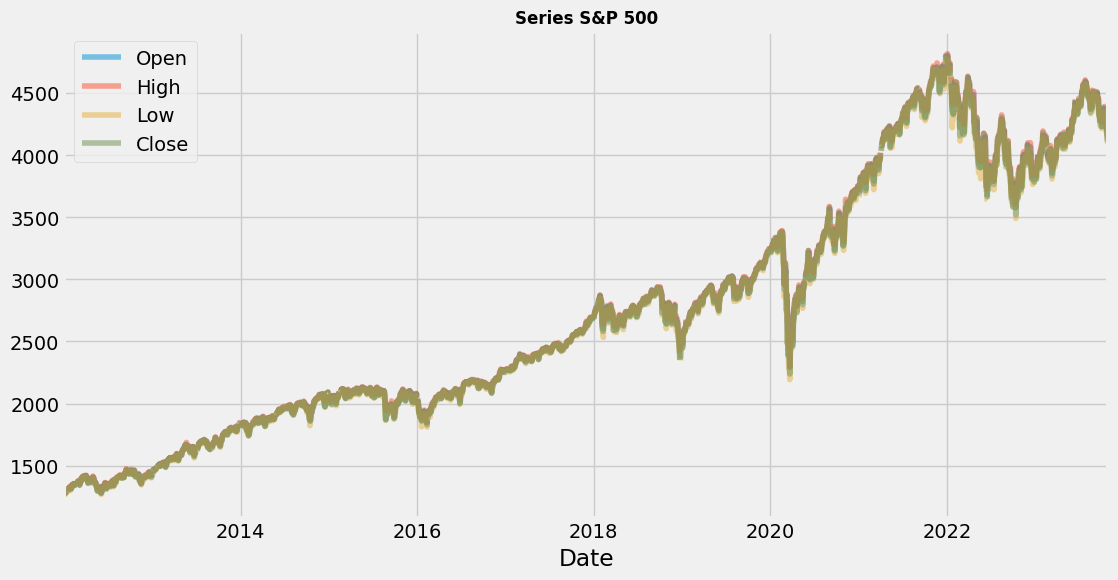

In [53]:
df[['Open', 'High', 'Low', 'Close']].plot(figsize=(12,6),alpha=0.5)
plt.title('Series S&P 500',fontsize=12,weight='bold')
plt.show()

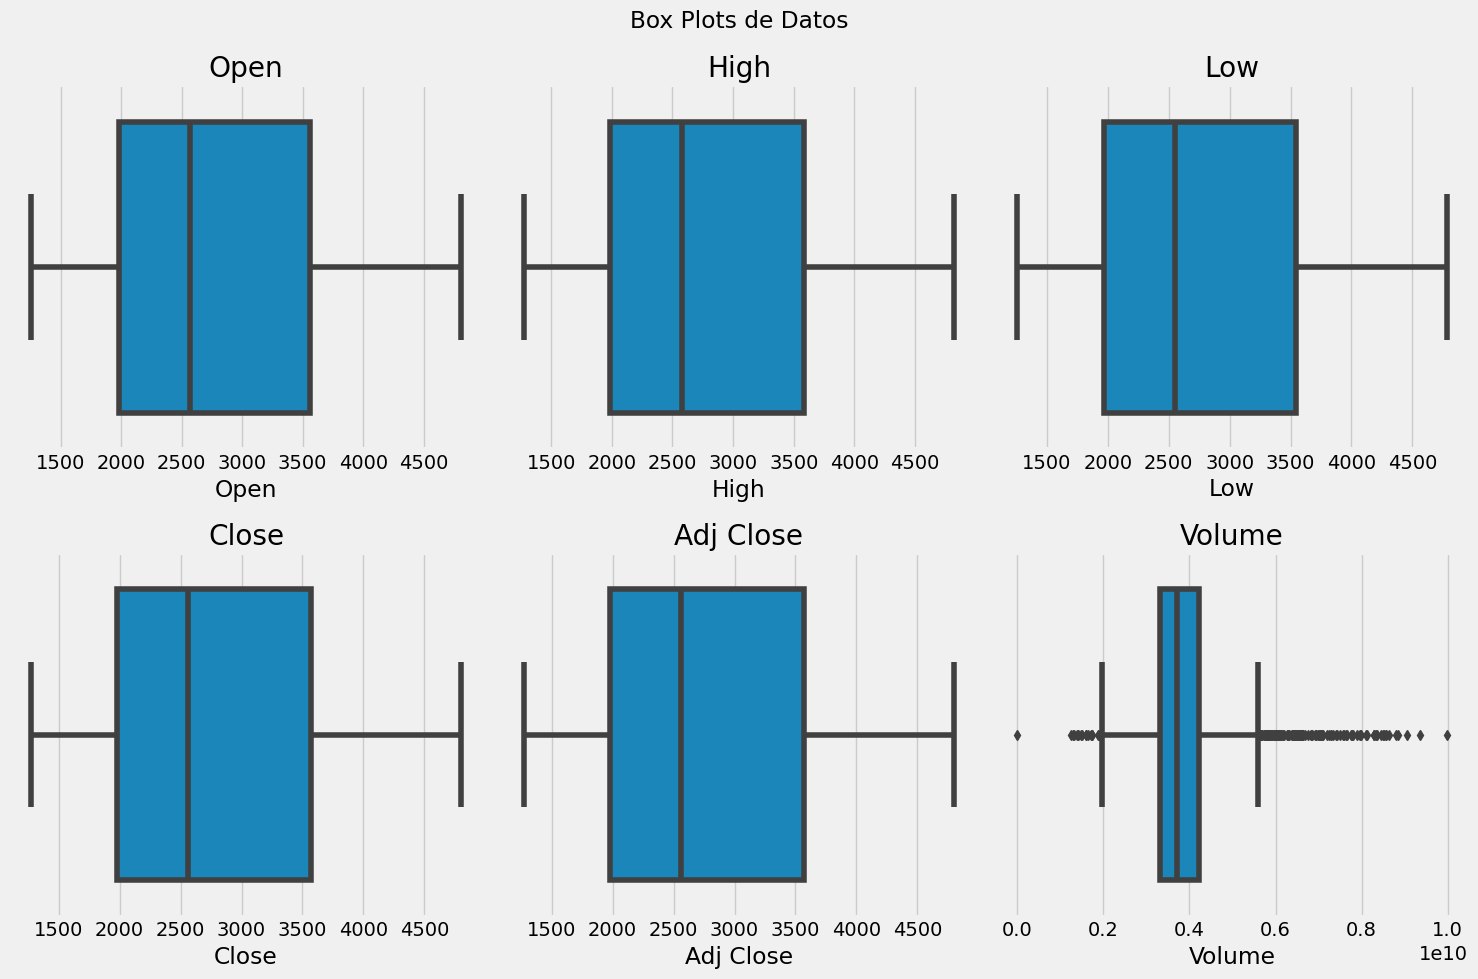

In [54]:
col=['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Crear una figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Box Plots de Datos')

# Iterar a través de las columnas y crear gráficos de caja en cada subparcela
for i, col_name in enumerate(col):
    row = i // 3  # Calcula la fila
    col_num = i % 3  # Calcula la columna
    sns.boxplot(data=df, x=col_name, ax=axes[row, col_num])
    axes[row, col_num].set_title(col_name)  # Establece el título de la subparcela

# Ajustar el espaciado entre subparcelas
plt.tight_layout()

# Mostrar los gráficos
plt.show()

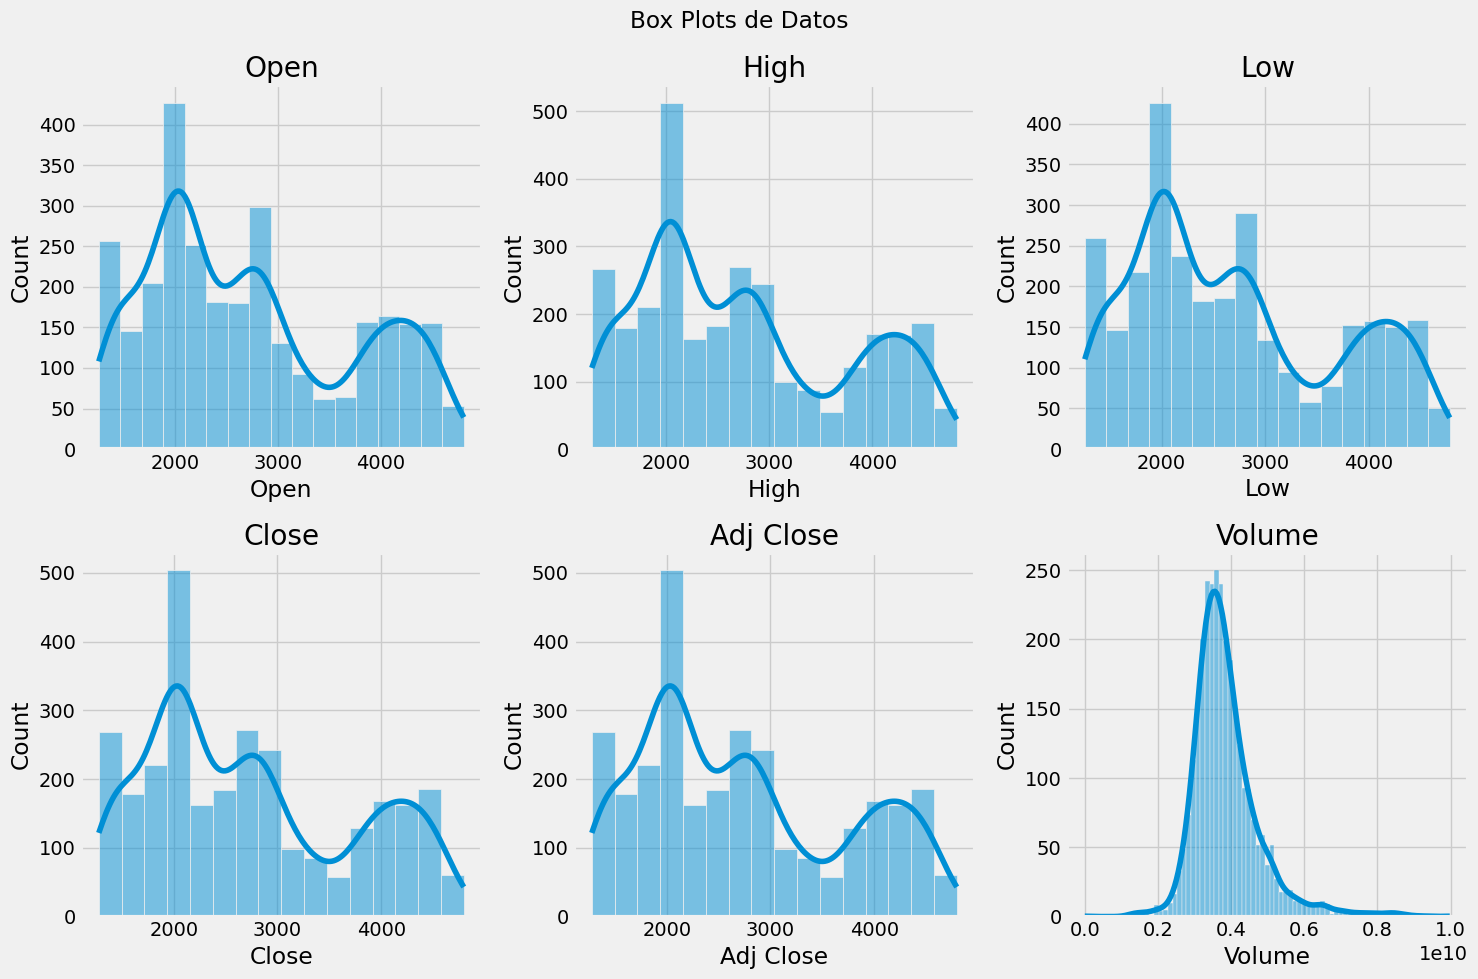

In [55]:

# Crear una figura con 2 filas y 3 columnas
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Box Plots de Datos')

# Iterar a través de las columnas y crear gráficos de caja en cada subparcela
for i, col_name in enumerate(col):
    row = i // 3  # Calcula la fila
    col_num = i % 3  # Calcula la columna
    sns.histplot(data=df, x=col_name,kde=True, ax=axes[row, col_num])
    axes[row, col_num].set_title(col_name)  # Establece el título de la subparcela

# Ajustar el espaciado entre subparcelas
plt.tight_layout()

# Mostrar los gráficos
plt.show()

In [56]:
df.fillna(method='ffill', inplace=True)

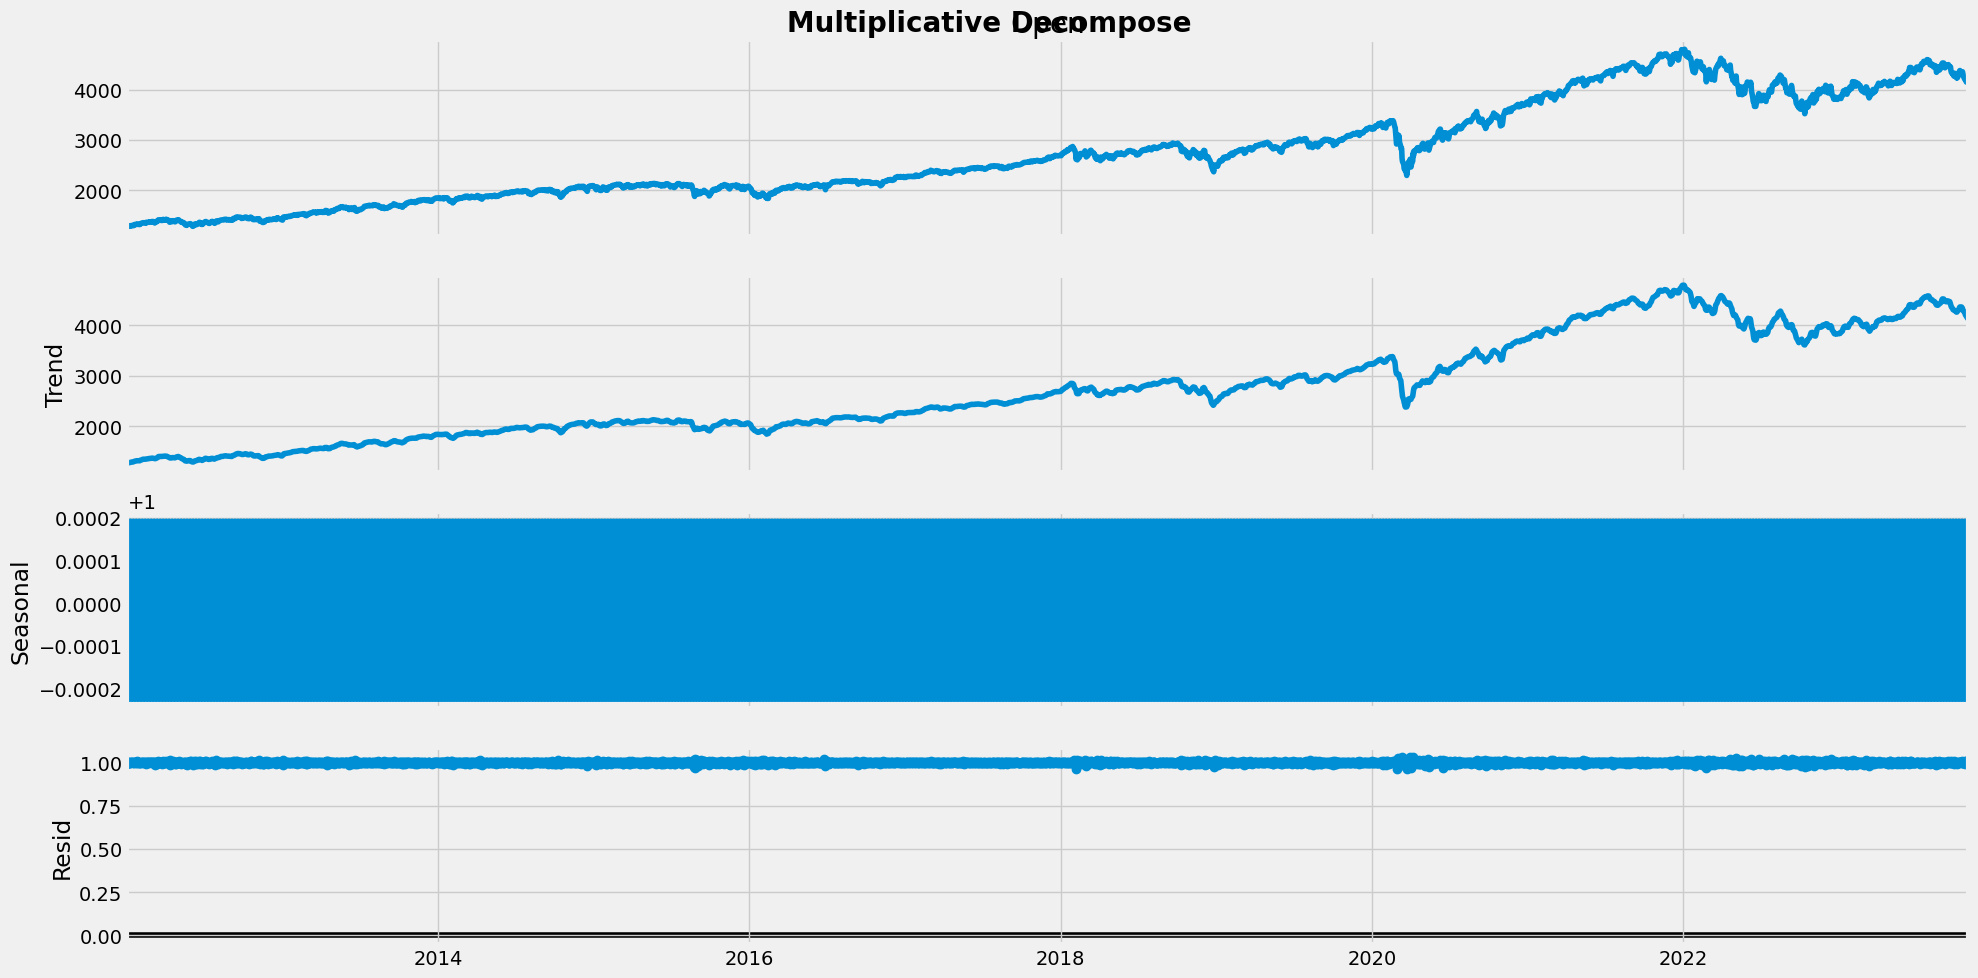

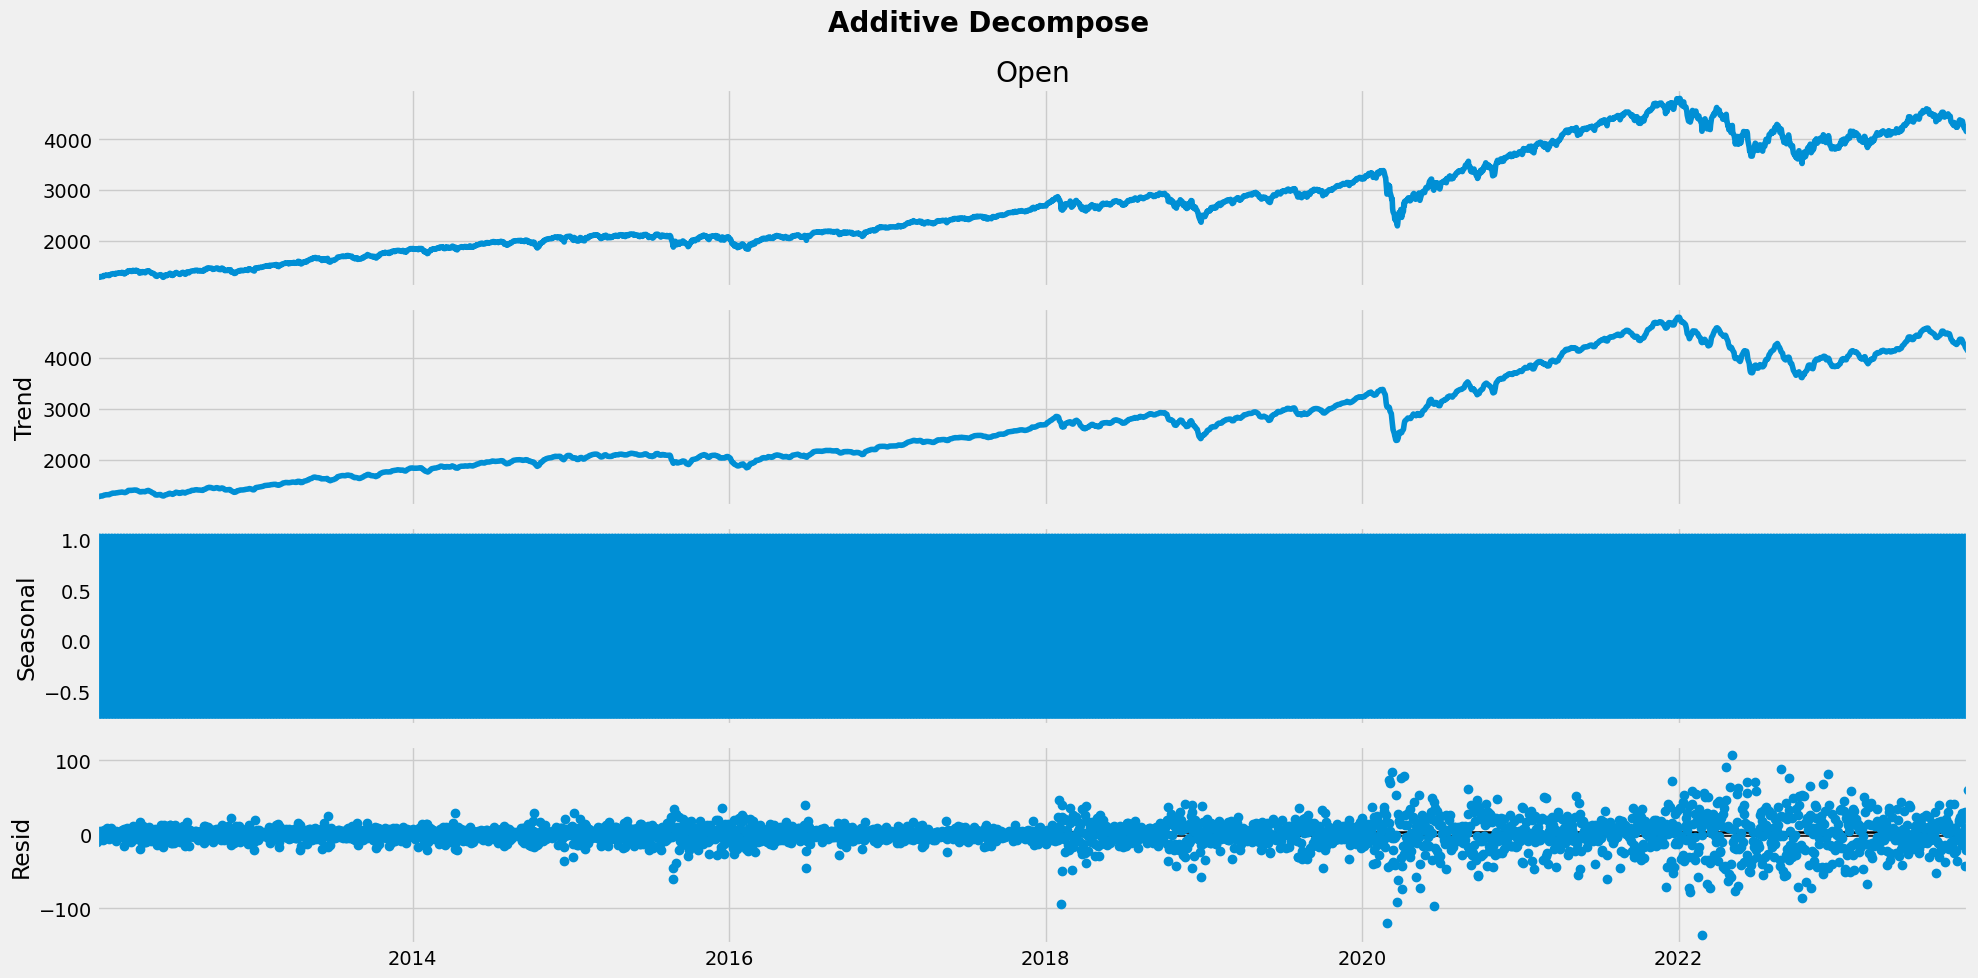

In [57]:
from statsmodels.tsa.seasonal import seasonal_decompose
def decompose(df, column_name):
    """
    A function that returns the trend, seasonality and residual captured by applying both multiplicative and
    additive model.
    df -> DataFrame
    column_name -> column_name for which trend, seasonality is to be captured
    """
    result_mul = seasonal_decompose(df[column_name], model='multiplicative', extrapolate_trend = 'freq')
    result_add = seasonal_decompose(df[column_name], model = 'additive', extrapolate_trend='freq')

    plt.rcParams.update({'figure.figsize': (20, 10)})
    result_mul.plot().suptitle('Multiplicative Decompose', fontsize=20,weight='bold')
    result_add.plot().suptitle('Additive Decompose', fontsize=20,weight='bold')
    plt.tight_layout()
    plt.show()

    return result_mul, result_add
result_mul, result_add = decompose(df, 'Open')

In [58]:
df_reconstructed_open = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis = 1)
df_reconstructed_open.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_open

,seas,trend,resid,actual_values
Date,,,,
2012-01-03,1.033369,1268.495640,-10.669024,1258.859985
2012-01-04,0.637270,1271.737832,4.654927,1277.030029
2012-01-05,-0.741823,1274.390015,3.651857,1277.300049
2012-01-06,-0.236249,1278.772021,2.394281,1280.930054
2012-01-09,-0.692568,1281.770020,-3.247496,1277.829956
...,...,...,...,...
2023-10-25,0.637270,4201.506055,30.276597,4232.419922
2023-10-26,-0.741823,4187.304102,-10.572045,4175.990234
2023-10-27,-0.236249,4174.412109,-21.245685,4152.930176


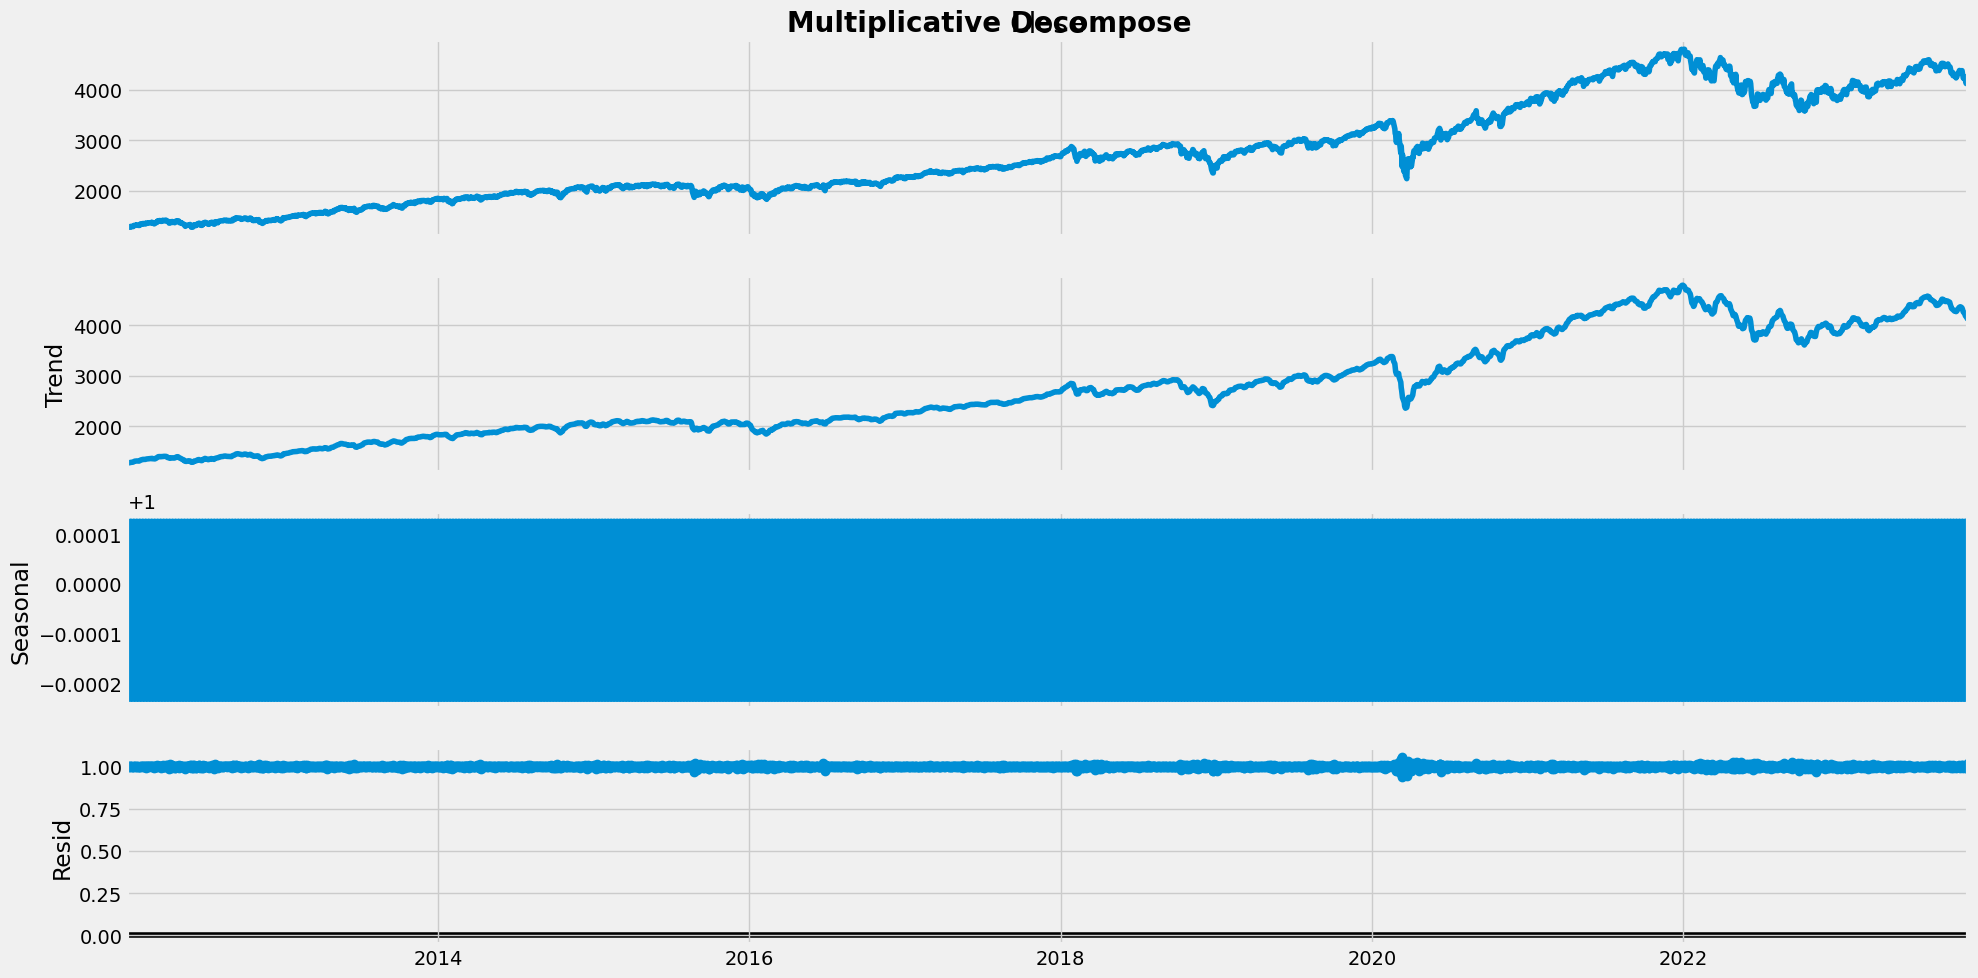

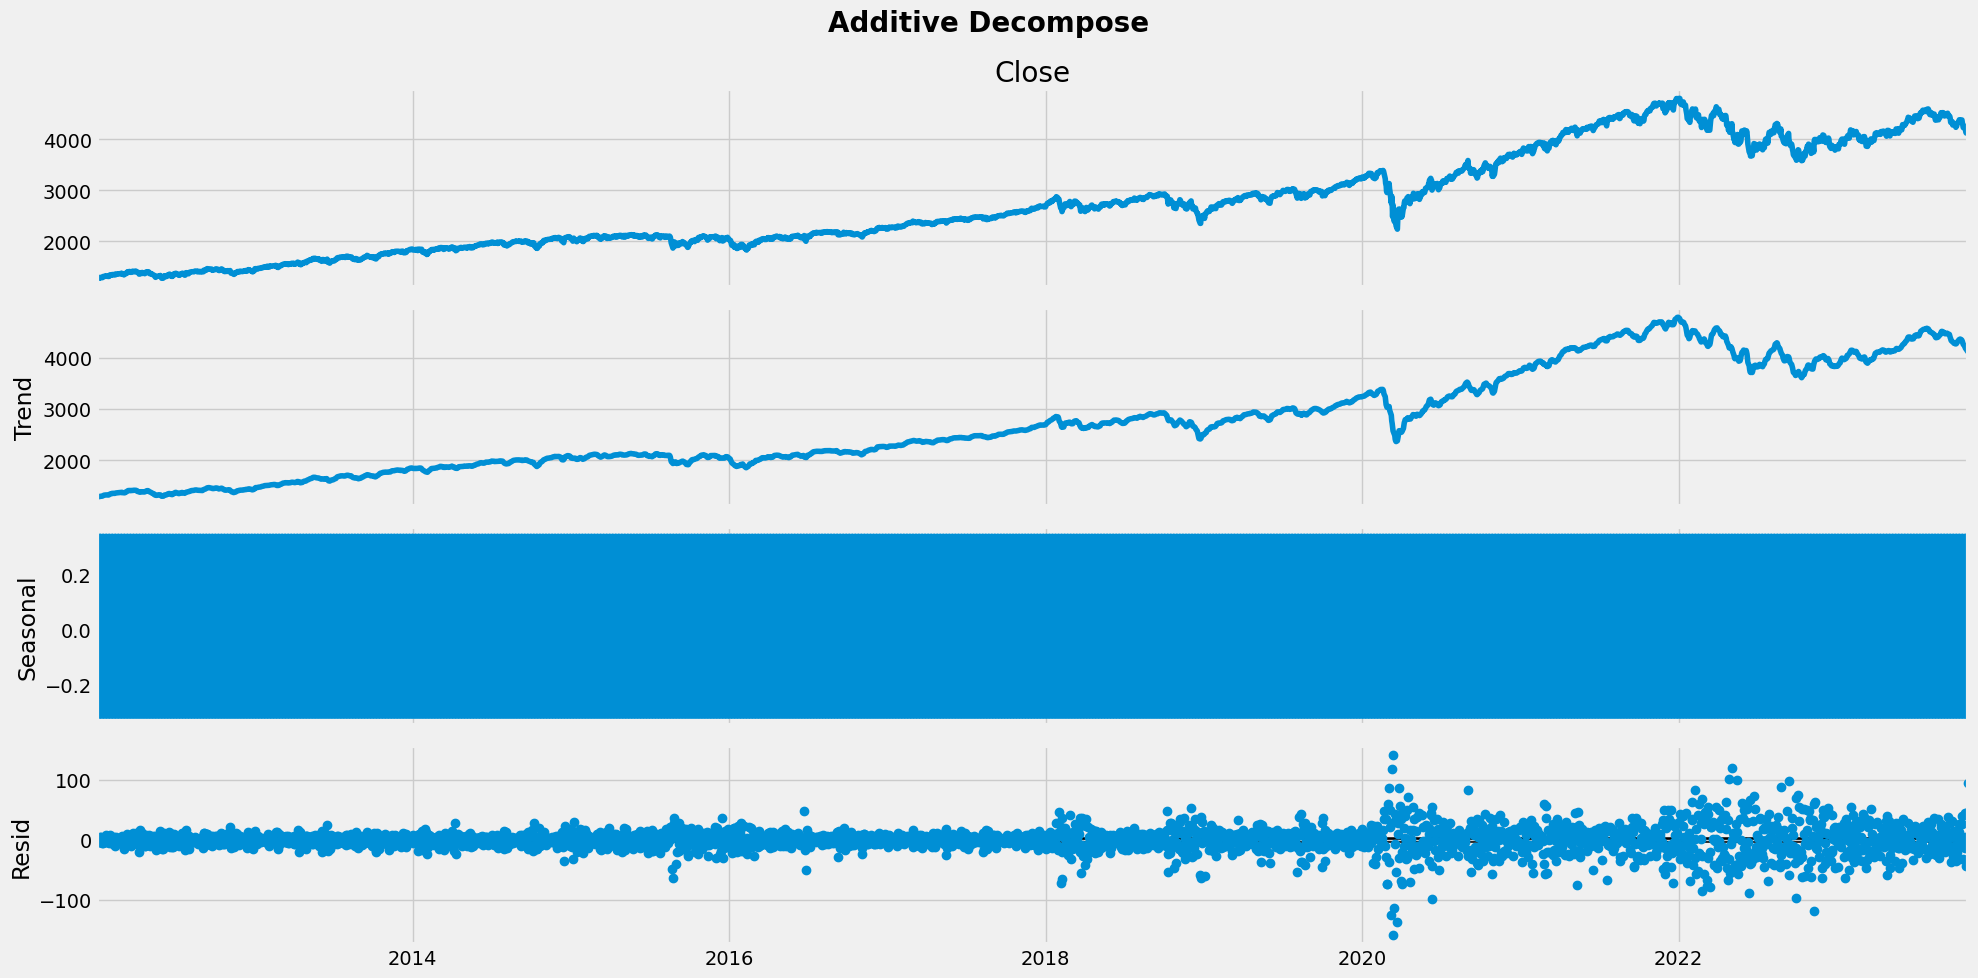

In [59]:
result_mul, result_add = decompose(df, 'Close')

In [60]:
df_reconstructed_close = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis = 1)
df_reconstructed_close.columns = ['seas', 'trend', 'resid', 'actual_values']
df_reconstructed_close

,seas,trend,resid,actual_values
Date,,,,
2012-01-03,0.174676,1273.300464,3.584919,1277.060059
2012-01-04,0.337032,1276.129648,0.833368,1277.300049
2012-01-05,-0.312644,1278.786035,2.586668,1281.060059
2012-01-06,0.041477,1281.790015,-4.021433,1277.810059
2012-01-09,-0.240542,1284.826001,-3.885508,1280.699951
...,...,...,...,...
2023-10-25,0.337032,4181.218066,5.214921,4186.770020
2023-10-26,-0.312644,4171.174023,-33.631399,4137.229980
2023-10-27,0.041477,4160.397949,-43.069309,4117.370117


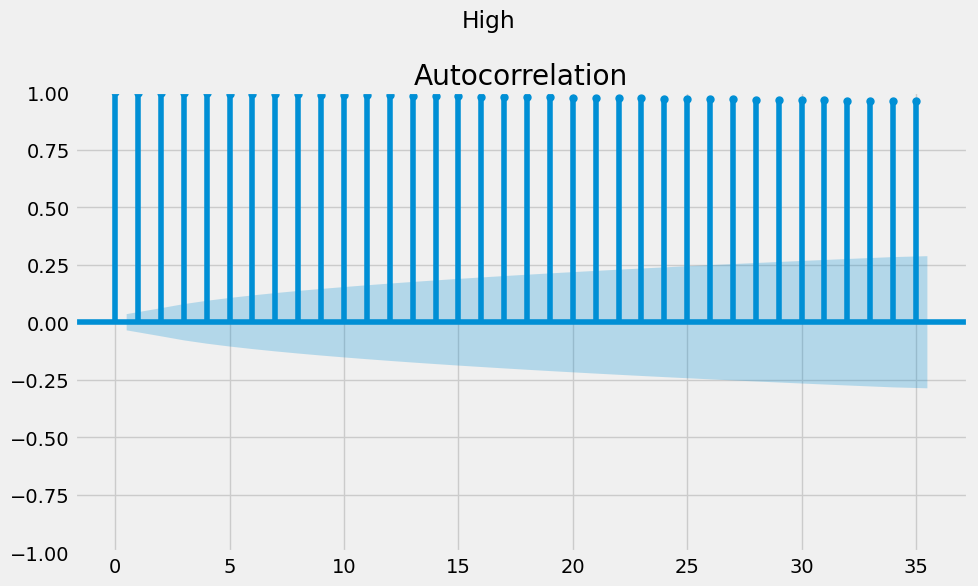

In [61]:
plt.rc("figure",figsize=(10,6))
plot_acf(df['High'])
plt.suptitle('High')
plt.tight_layout()
print()

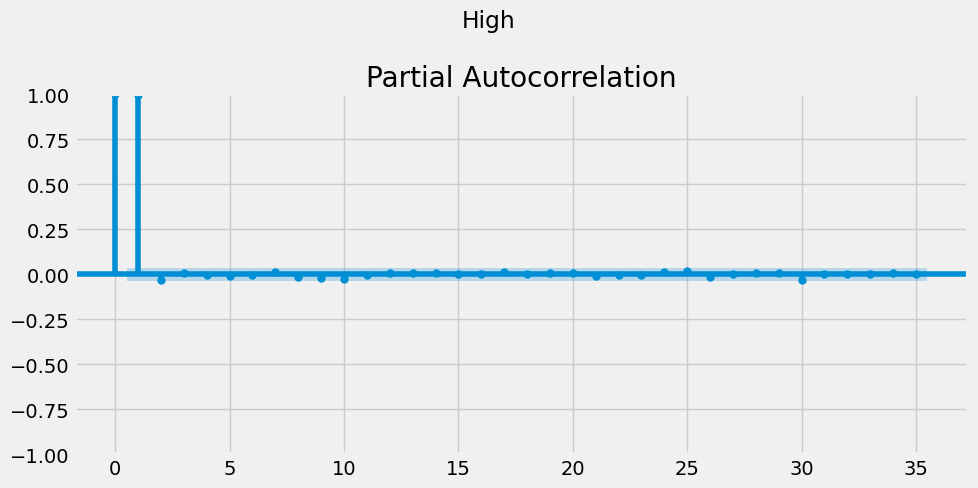

In [62]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['High'])
plt.suptitle('High')
plt.tight_layout()
print()

In [63]:
def Prueba_Dickey_Fuller(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [64]:
Prueba_Dickey_Fuller(df["High"],"High")

Resultados de la prueba de Dickey-Fuller para columna: High
Test Statistic                          -0.664726
p-value                                  0.855676
No Lags Used                            29.000000
Número de observaciones utilizadas    3056.000000
Critical Value (1%)                     -3.432492
Critical Value (5%)                     -2.862486
Critical Value (10%)                    -2.567274
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


## **Modeling LSTM**

In [65]:
print(df.shape)
new_df=df['High'].iloc[:-4]
print(new_df.shape)

(3086, 6)
(3082,)


In [66]:
train_len=math.ceil(len(new_df)*0.8)
print(train_len)

2466


In [67]:
window=10
train_data = new_df[0:train_len]
X_train=[]
Y_train=[]
for i in range(window, len(train_data)):
    X_train.append(train_data[i-window:i])
    Y_train.append(train_data[i])
X_train,Y_train=np.array(X_train),np.array(Y_train)

In [68]:
X_train, Y_train= np.array(X_train), np.array(Y_train)

In [69]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2456, 10, 1)

In [70]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [71]:
model=Sequential()
model.add(LSTM(50,activation='relu',input_shape=(X_train.shape[1],1)))
model.add(Dense(25))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')
model.summary()
model.fit(X_train,Y_train,epochs=10,batch_size=10,verbose=0)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 1)                 26        
                                                                 
Total params: 11701 (45.71 KB)
Trainable params: 11701 (45.71 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:
test_data=new_df[train_len - window:]
X_val=[]
Y_val=[]
for i in range(window, len(test_data)):
    X_val.append(test_data[i-window:i])
    Y_val.append(test_data[i])

In [73]:
X_val, Y_val = np.array(X_val), np.array(Y_val)
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1],1))

In [75]:
print(X_val.shape)
print(Y_val.shape)

(616, 10, 1)
(616,)


In [76]:
prediction = model.predict(X_val)
len(prediction), len(Y_val)

20/20 [==============================] - 1s 7ms/step


(616, 616)

In [80]:
from sklearn.metrics import mean_squared_error

lstm_train_pred = model.predict(X_train)
lstm_valid_pred = model.predict(X_val)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_val, lstm_valid_pred)))


20/20 [==============================] - 0s 2ms/step
Train rmse: 48.085982571037405
Validation rmse: 96.10191125327819


In [81]:
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred
valid

,High,Predictions
Date,,
2021-06-16,4251.890137,4295.162109
2021-06-17,4232.290039,4297.917480
2021-06-18,4204.779785,4299.022461
2021-06-21,4226.240234,4294.087402
2021-06-22,4255.839844,4295.466309
...,...,...
2023-10-19,4339.540039,4417.709961
2023-10-20,4276.560059,4422.791504
2023-10-23,4255.839844,4413.689941


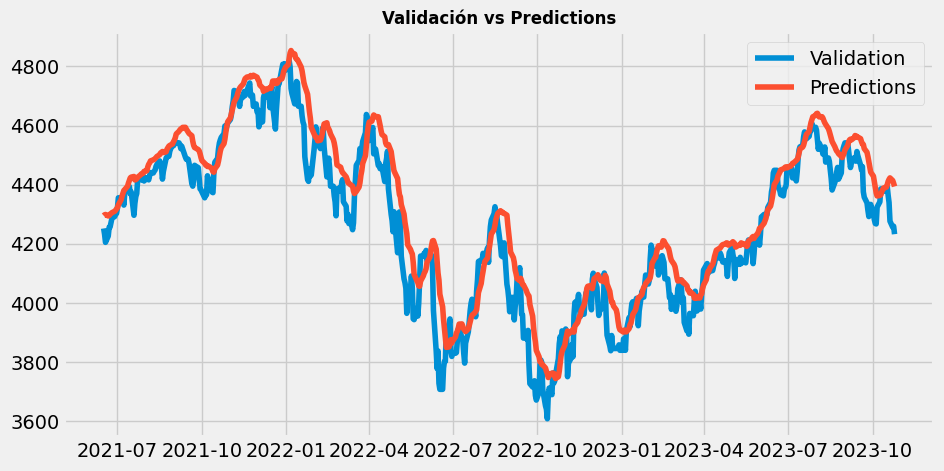

In [83]:
plt.plot(valid[['High','Predictions']])
plt.legend(['Validation','Predictions'])
plt.title('Validación vs Predictions',fontsize=12,weight='bold')
plt.show()

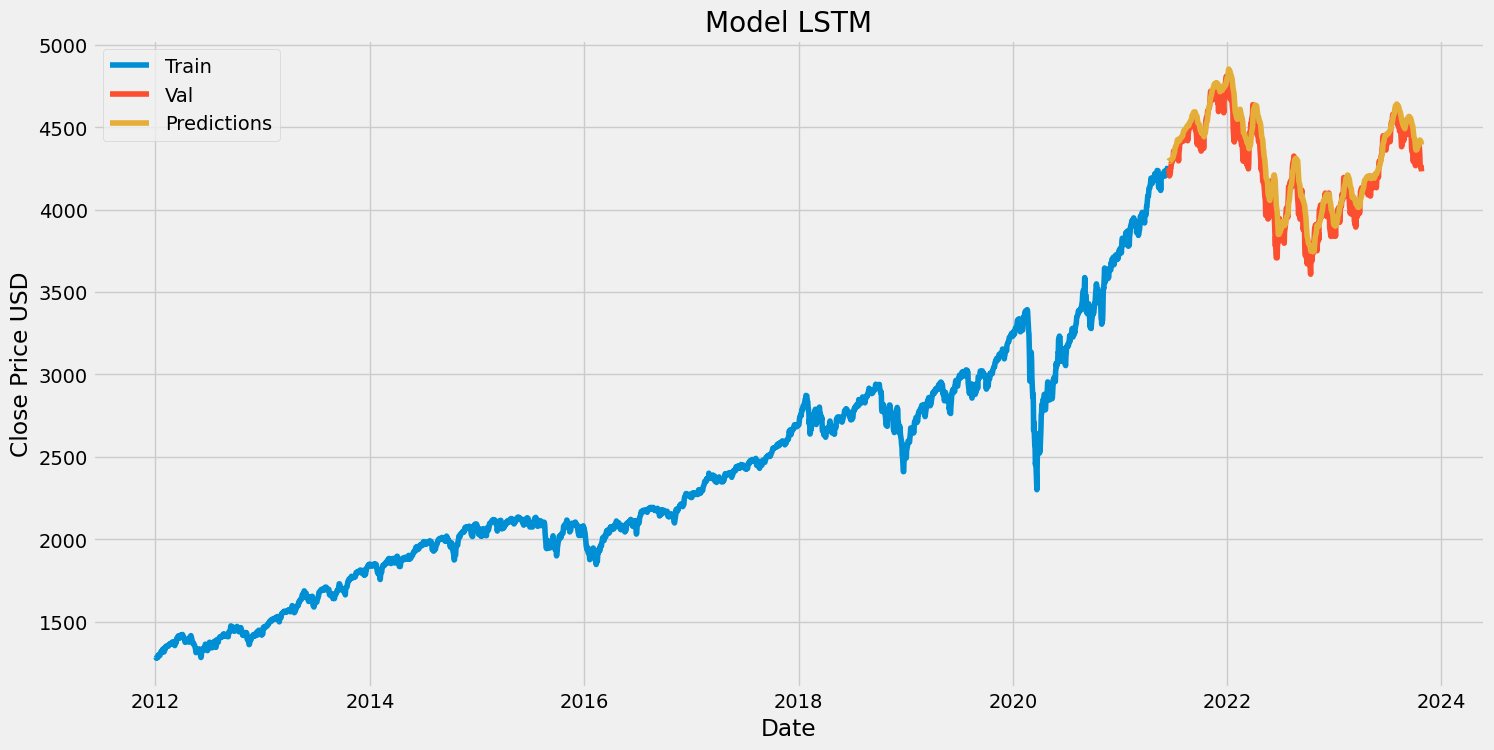

In [84]:
train = new_df[:train_len]
valid = pd.DataFrame(new_df[train_len:])
valid['Predictions']=lstm_valid_pred

plt.figure(figsize=(16,8))
plt.title('Model LSTM')
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.plot(train)
plt.plot(valid[['High','Predictions']])
plt.legend(['Train','Val','Predictions'])
plt.show()